In [1]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, multilabel_confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
import random
import time
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import hamming_loss, classification_report
from sklearn.multioutput import MultiOutputClassifier
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsClassifier

## Loading Data from data.npy

In [2]:
data = np.load("data.npy", allow_pickle=True)

N = len(data)

print("Number of entries in the given dataset is: " + str(N))

Number of entries in the given dataset is: 1500


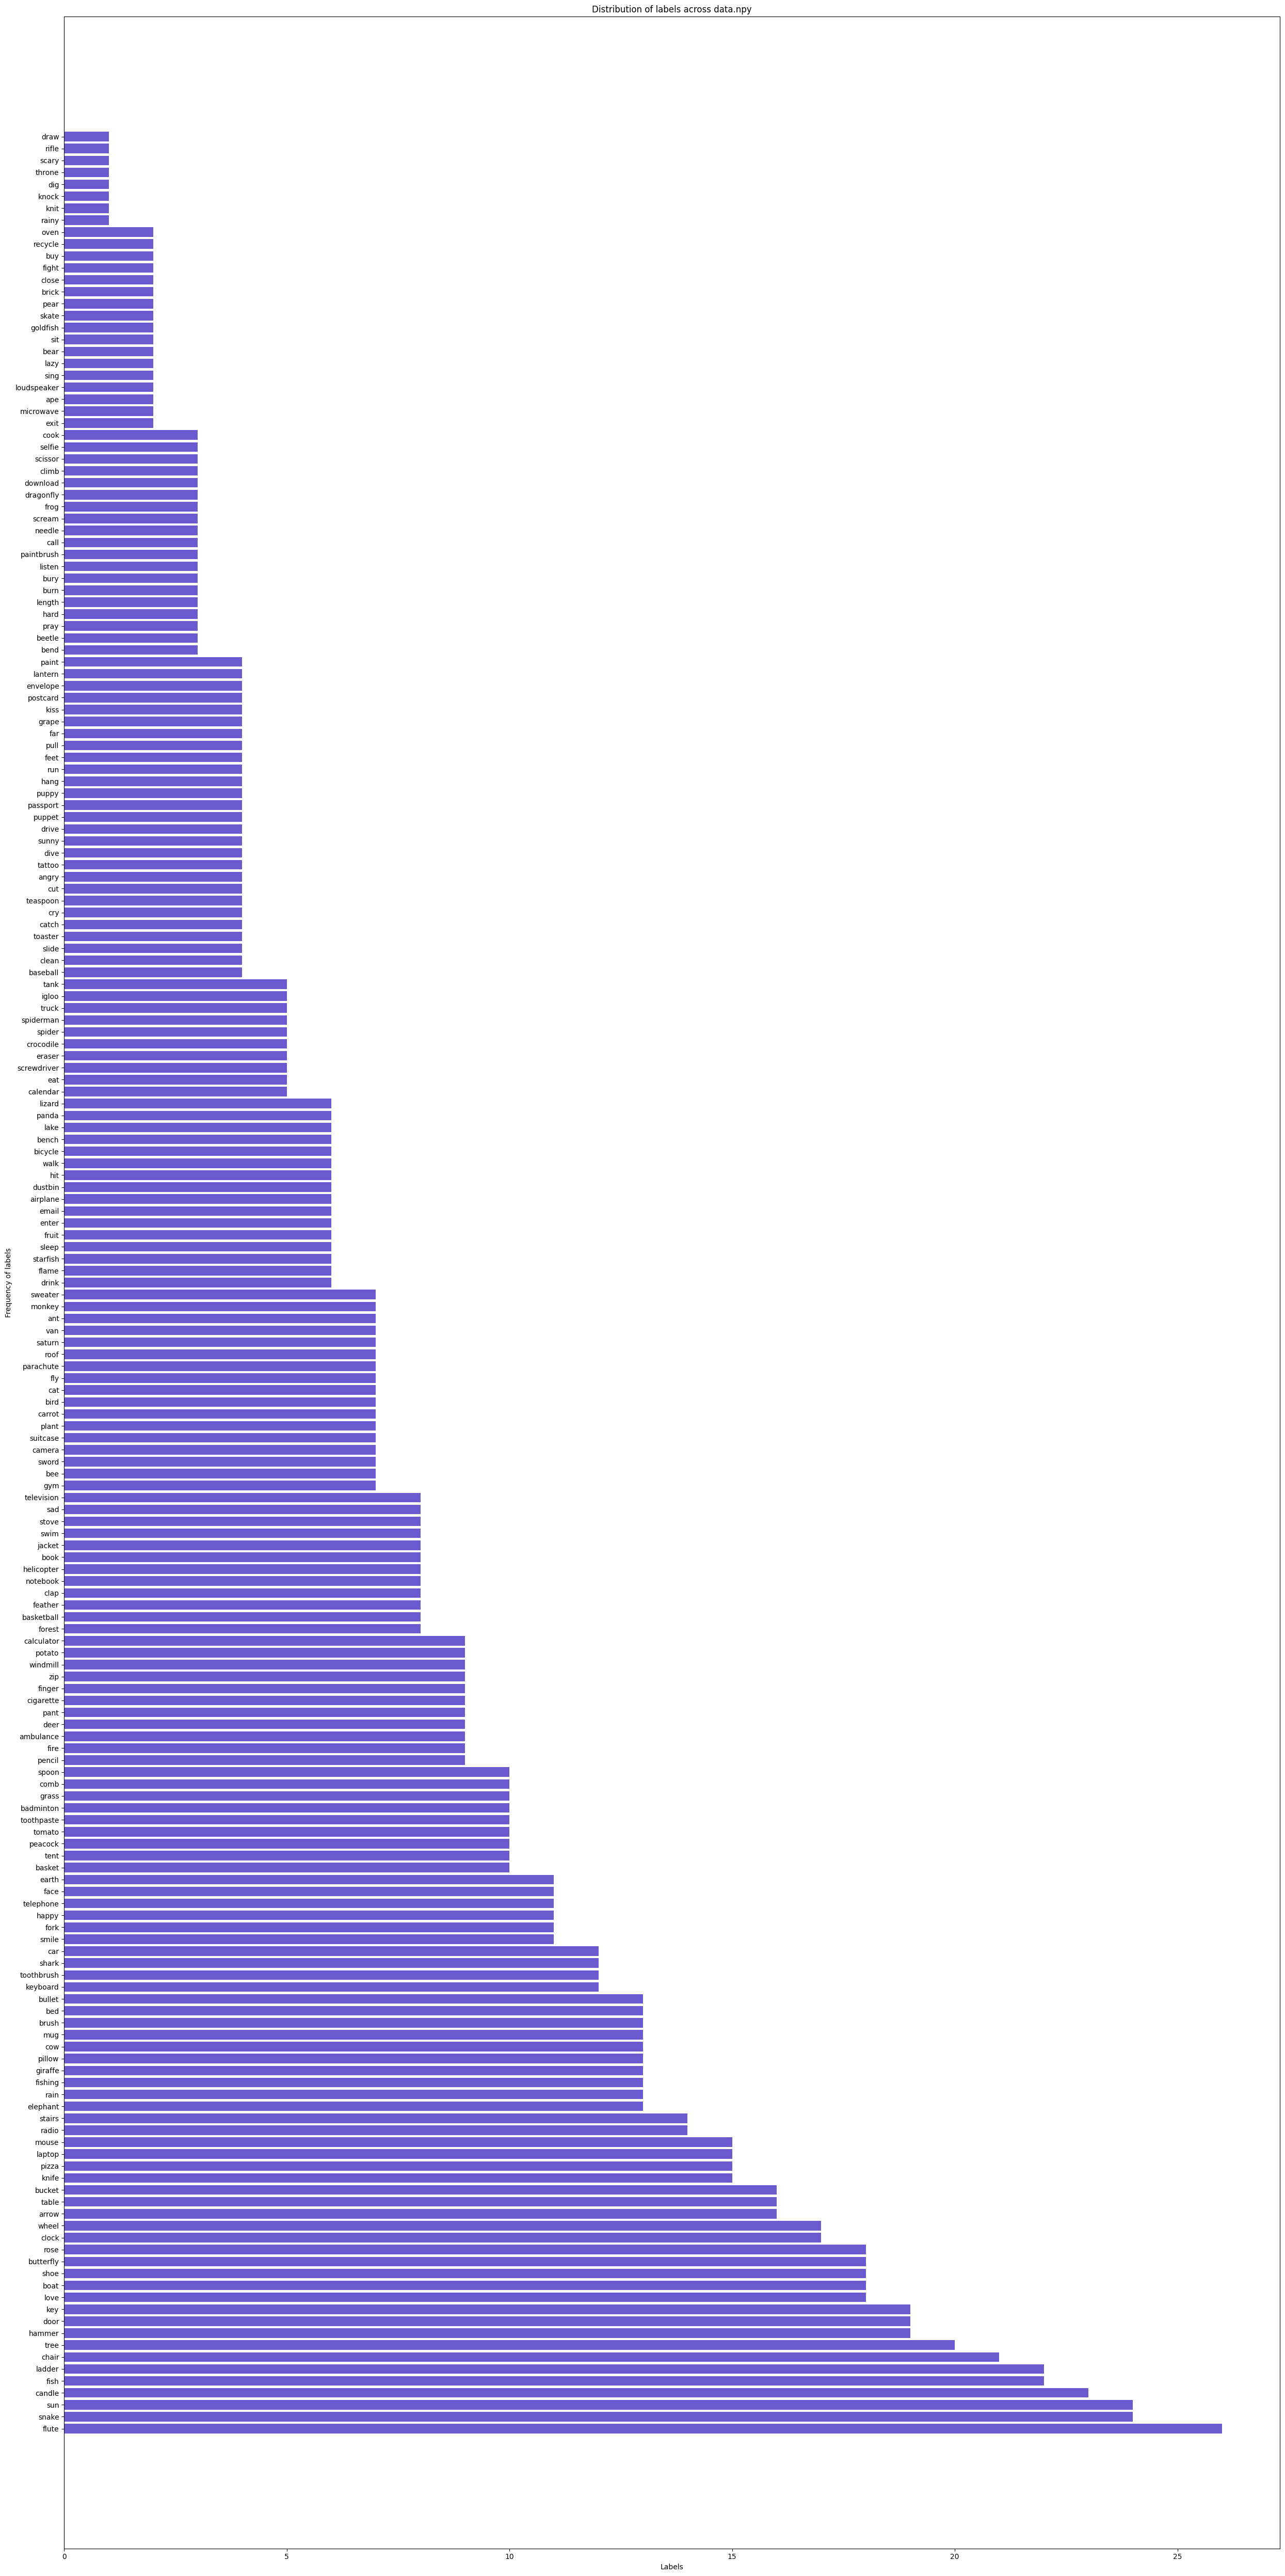

In [3]:
# Stores list of all labels in the given dataset "data"

labels = data[:,3]

# unique_labels stores the different labels present in the "labels" list

# frequency_labels store the count of those "labels" 

unique_labels, frequency_labels = np.unique(labels, return_counts = True)

# The next 3 lines of code have been generated using ChatGPT
# Prompt: How to sort 2 numpy arrays which are connected by the values of 2nd numpy array
sorted_indices = np.argsort(frequency_labels)[::-1]
f_labels = frequency_labels[sorted_indices]
u_labels = unique_labels[sorted_indices]

# Observation that maximum frequency of a given label is at most 26

plt.figure(figsize=(25,50))
bars = plt.barh(u_labels, f_labels, color ='slateblue')

plt.xlabel("Labels")
plt.ylabel("Frequency of labels")
plt.title("Distribution of labels across data.npy")

plt.tight_layout()
plt.show()

In [4]:
# The functions for Euclidean, Manhattan and Cosine have been mainly generated using ChatGPT.
# Minor tweaks have been made for vectorization.
# Prompt: Given 2 np arrays find the cosine,euclidean and manhattan distance between them using numpy.

# The axis = -1 is there because we have vectorized the code so that we can directly find distances from all points in the training data set to avoid the for-loop


class kNearestNeighbours:
    def __init__(self, encoder, k, distance_metric, train_data):
        self.k = k;
        self.encoder = encoder
        self.distance_metric = distance_metric
        self.train_data = train_data
        
    def setParams(self, encoder, k, distance_metric):
        self.k = k;
        self.encoder = encoder
        self.distance_metric = distance_metric
        
    def Euclidean(self,a, b):
        return np.sqrt(np.sum((a-b)**2,axis=-1))

    def Manhattan(self,a, b):
        return np.sum(np.abs(a - b),axis=-1)
    
    def Cosine(self,a, b):
        dot_product = np.dot(a, b)
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        cosine_similarity = dot_product / (norm_a * norm_b)
        cosine_distance = 1 - cosine_similarity
        return cosine_distance

    def getPrediction(self,train_data,tdata_point):
        d_list = []
        list_features = train_data[:,0]
        list_labels = train_data[:,1]
        t_data = np.vstack(list_features)
        
        if(self.distance_metric=='euclidean'):
            d_list = self.Euclidean(t_data,tdata_point[0])
        elif(self.distance_metric=='manhattan'):
            d_list = self.Manhattan(t_data,tdata_point[0])
        else:
            d_list = self.Cosine(t_data,tdata_point[0])
        
        datype = [('col1', float), ('col2', 'U20')]
        
        # Creating new empty n*2 numpy array so that tuple of distances and labels can be stored together
        dist_list = np.empty((len(d_list),2), dtype='object')    
        dist_list[:,0] = d_list
        dist_list[:,1] = list_labels
        
        # The next line has been generated using ChatGPT
        # Prompt: Write python code to extract minimum k elements in a 2d list by value of 1st element using numpy functions
        k_labels = dist_list[np.argsort(dist_list[:,0])[:self.k]]

        unique_elements, counts = np.unique(k_labels[:,1], return_counts=True)
        max_count_frequency = np.max(counts)
        
        # The next 2 lines have been generated using ChatGPT
        # Prompt: How to extract all labels whose frequency is maximum in a given array and the frequency is known.
        values_with_max_freq = unique_elements[counts == max_count_frequency]
        min_dist_el = k_labels[np.isin(k_labels[:,1],values_with_max_freq)]

        # The next line has been generated using ChatGPT
        # Prompt: How to find inverse of distances using numpy.
        values = 1 / (1 + min_dist_el[:, 0])
        
        keys,ind = np.unique(min_dist_el[:, 1],return_inverse=True)
        
        # The next 3 lines have been generated using ChatGPT
        # Prompt: How to get array element with maximum frequency in np array
        sums = np.bincount(ind, weights=values.astype(float))
        
        max_idx = np.argmax(sums)
        prediction = keys[max_idx]
        
        return prediction            
        
    def predictClass(self, test_data):
        train_features = None
        test_features = None
        
        predicted_labels = []
        true_labels = test_data[:,3]
        
        if(self.encoder == 'resnet'):
            train_features = train_data[:, [1,3]]
            test_features = test_data[:, [1,3]]
        else:
            train_features = train_data[:, [2,3]]
            test_features = test_data[:, [2,3]]
            
        for i in test_features:
            label = self.getPrediction(train_features,i[0])
            predicted_labels.append(label)
            
        f1score = f1_score(true_labels, predicted_labels, average = "weighted", zero_division=1) 
        recall = recall_score(true_labels, predicted_labels, average = "weighted", zero_division=1)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average = "weighted", zero_division=1)
        
        return f1score, accuracy, precision, recall

In [5]:
# ChatGPT Prompt : write numpy code to split training data into 80-20

split_point = int(0.8 * len(data))
train_data, validation_data = data[:split_point], data[split_point:]

encoders = ['resnet','vit']
distance_metrics = ['euclidean','manhattan','cosine']

In [7]:
kNN = kNearestNeighbours('resnet',1,'euclidean',train_data)
accuracytot = 0
hypertuples = None

all_params = []

start_time = time.time()
for i in encoders:
    for j in distance_metrics:
        for k in range(1,40):
            kNN.setParams(i,k,j)
            f1score, accuracy, precision, recall = kNN.predictClass(validation_data)
            if accuracy > accuracytot:
                hypertuples = [i,j,k]
                accuracytot = accuracy
            all_params.append([accuracy,k,i,j])
end_time = time.time()

print("Time for Hyperparameter Tuning: " + str(end_time-start_time) + " seconds")
print()

sorted_indices = np.argsort(np.array(all_params)[:, 0])[::-1]
sorted_data = np.array(all_params)[sorted_indices][:20]

print("Best Hyperparameter triplet for the current data split is: k = " + str(hypertuples[2]) + ", distance metric = " + str(hypertuples[1]) + ", encoder = " + str(hypertuples[0]))
print()

print("Top 20 triplets in terms of Validation accuracy for the current split are: ")

table_20 = PrettyTable()
table_20.field_names = ["Encoder", "Distance Metric","k","Accuracy"]

for row in sorted_data:
    table_20.add_row([row[2],row[3],row[1],row[0]])
    
print()
print(table_20)

Time for Hyperparameter Tuning: 204.40977358818054 seconds

Best Hyperparameter triplet for the current data split is: k = 10, distance metric = euclidean, encoder = vit

Top 20 triplets in terms of Validation accuracy for the current split are: 

+---------+-----------------+----+---------------------+
| Encoder | Distance Metric | k  |       Accuracy      |
+---------+-----------------+----+---------------------+
|   vit   |    euclidean    | 10 | 0.31333333333333335 |
|   vit   |    euclidean    | 9  |         0.31        |
|   vit   |    euclidean    | 8  | 0.30666666666666664 |
|   vit   |    manhattan    | 8  | 0.30333333333333334 |
|   vit   |    manhattan    | 9  | 0.30333333333333334 |
|   vit   |    manhattan    | 7  |         0.3         |
|   vit   |    manhattan    | 13 |         0.3         |
|   vit   |    manhattan    | 14 |         0.3         |
|   vit   |    euclidean    | 11 |         0.3         |
|   vit   |    manhattan    | 17 |         0.3         |
|   vit   |

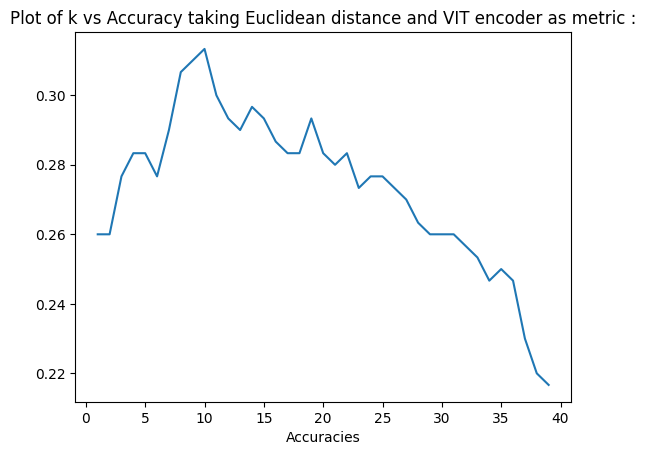

In [8]:
encoder = 'vit'
distance_metric = 'euclidean'

kNN_plot = kNearestNeighbours(encoder,1,distance_metric,train_data)

k = []
accuracies = []

for i in range(1,40):
    kNN_plot.setParams(encoder,i,distance_metric)
    f1score, accuracy, precision, recall = kNN_plot.predictClass(validation_data)
    k.append(i)
    accuracies.append(accuracy)
    
plt.plot(k,accuracies)
plt.xlabel("k")
plt.xlabel("Accuracies")
plt.title("Plot of k vs Accuracy taking Euclidean distance and VIT encoder as metric :")
plt.show()

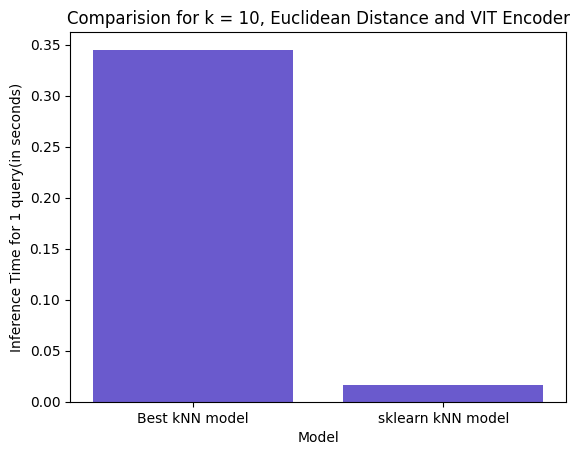

In [63]:
encoder = 'vit'
distance_metric = 'euclidean'

my_kNN = kNearestNeighbours(encoder,10,distance_metric,train_data)
sklearn_kNN = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')


X_train, X_test, Y_train, Y_test = train_test_split(data[:,2], data[:,3], test_size=0.2)      

y = []
x = ["Best kNN model" , "sklearn kNN model"]
# Note: My initial kNN and optimized kNN models are the same.

start_time = time.time()
f1score, accuracy, precision, recall = my_kNN.predictClass(validation_data)
end_time = time.time()

y.append(end_time-start_time)

start_time = time.time()
sklearn_kNN.fit(np.vstack(X_train),Y_train)
Y_pred = sklearn_kNN.predict(np.vstack(X_test))
end_time = time.time()

y.append(end_time-start_time)

plt.bar(x,y, color ='slateblue')
plt.title("Comparision for k = 10, Euclidean Distance and VIT Encoder")
plt.xlabel("Model")
plt.ylabel("Inference Time for 1 query(in seconds)")
plt.show()

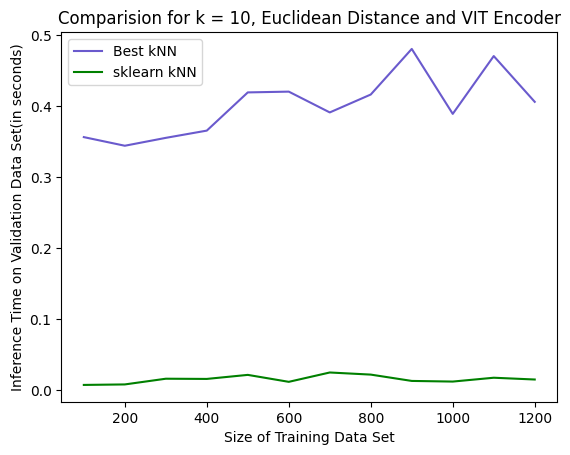

In [64]:
encoder = 'vit'
distance_metric = 'euclidean'

y_myKNN = []
y_sklearnKNN = []
x = []

for i in range (100,1300,100):
    kNN_diffsize = kNearestNeighbours(encoder,10,distance_metric,train_data[:i])
    st_time = time.time()
    f1score, accuracy, precision, recall = kNN_diffsize.predictClass(validation_data)
    end_time = time.time()
    y_myKNN.append(end_time-st_time)
    
    kNN_diffsize = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')
    st_time = time.time()
    kNN_diffsize.fit(np.vstack(train_data[:,2][:i]),train_data[:,3][:i])
    Y_pred = kNN_diffsize.predict(np.vstack(validation_data[:,2]))
    end_time = time.time()
    y_sklearnKNN.append(end_time-st_time)
    
    
    x.append(i)

plt.plot(x,y_myKNN, label = 'Best kNN' ,color ='slateblue')
plt.plot(x, y_sklearnKNN, label = 'sklearn kNN',color='green')
plt.title("Comparision for k = 10, Euclidean Distance and VIT Encoder")
plt.xlabel("Size of Training Data Set")
plt.ylabel("Inference Time on Validation Data Set(in seconds)")
plt.legend()
plt.show()

## Observation:

### The graph above leads us to conclude that for the vectorized code, there is no stark difference on the size of training data on the time taken for predicting. Also the time taken into account is only for the run on validation set and not for instantiation of the kNN class.

## Decision Tree

In [26]:
df = pd.read_csv("advertisement.csv")

print("Data from advertisement.csv: ")
print()
print(df)

inpX = df.iloc[:, :-1]
inpY = df.iloc[:, -1].str.split(' ')

Data from advertisement.csv: 

     age  gender        income    education  married  children           city  \
0     45    Male  61271.953359       Master    False         3    Lake Sheila   
1     24  Female  53229.101074  High School    False         1   Crystalburgh   
2     45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3     19    Male  48950.246384          PhD    False         0  Williamshaven   
4     29  Female  44792.627094       Master    False         0       New Paul   
..   ...     ...           ...          ...      ...       ...            ...   
995   61    Male  34246.773063       Master     True         3      Solisfurt   
996   56  Female  45494.225591     Bachelor    False         0    Dawsonmouth   
997   64  Female  68740.442006          PhD     True         0  Lake Garyport   
998   18  Female  44348.446680     Bachelor     True         0       Ericfurt   
999   61    Male  39160.083677       Master    False         0      Port Jose 

In [27]:
numerical_features = [cname for cname in inpX.columns if inpX[cname].dtype in ['int64', 'float64']]
categorical_features = [cname for cname in inpX.columns if inpX[cname].dtype=='object']
binary_features = [cname for cname in inpX.columns if inpX[cname].dtype=='bool']

for col in categorical_features:
    unique_values = inpX[col].value_counts()
    print(f"Categorical Column Name: {col}")
    print()
    print(unique_values)
    print()

for col in binary_features:
    unique_values = inpX[col].value_counts()
    print(f"Binary Column Name: {col}")
    print()
    print(unique_values)
    print()

Categorical Column Name: gender

Female    506
Male      494
Name: gender, dtype: int64

Categorical Column Name: education

Master         269
PhD            252
High School    240
Bachelor       239
Name: education, dtype: int64

Categorical Column Name: city

Michaelberg     3
East John       3
West Robert     2
New Kathryn     2
North Andrew    2
               ..
Rosstown        1
Kevintown       1
Kirkland        1
New Monica      1
Port Jose       1
Name: city, Length: 969, dtype: int64

Categorical Column Name: occupation

Scientist      104
HR             102
Lawyer          95
Unemployed      95
Businessman     93
Engineer        91
Artist          88
Retired         88
Salesman        85
Housewife       82
Doctor          77
Name: occupation, dtype: int64

Categorical Column Name: most bought item

carpet          51
lipstick        51
ball            50
novel           49
bat             49
pants           48
gloves          47
shoes           47
shirt           47
dictiona

## Observation:

### We can clearly see from the data that the categorical column "city" has a total of 969 unique values with a maximum label frequency of 3. Thus, it is a bad feature to be present for fitting in the decision tree and hence it would be ideal to drop it before running our decision tree so that the model does not learn from this particular feature as it is misleading.

### All other features look fairly distributed and hence there is no need to make any other changes to the data

## Dropping Categorical Feature "city" column from DataFrame

In [28]:
inpX.drop('city', axis = 1,inplace = True)

categorical_features = [cname for cname in inpX.columns if inpX[cname].dtype=='object']

In [29]:
inpY = [set(label_list) for label_list in inpY]

mlb = MultiLabelBinarizer()

finalY = mlb.fit_transform(inpY)

In [30]:
X_train, X_test, Y_train, Y_test  =  train_test_split(inpX, finalY, test_size=0.2, random_state=42)

## Normalizing Numerical Features and doing Ordinal Encoding for Categorical Features

In [31]:
scaler = StandardScaler()

for feature in categorical_features:
    encoder = LabelEncoder()
    X_train[feature] = encoder.fit_transform(X_train[feature])
    X_test[feature] = encoder.transform(X_test[feature])

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

## Observation:

### LabelEncoder was used instead of OneHotEncoder in order to reduce the input data dimensionality. Another reason for doing this was due to the hyperparameter list given to tune the data. LabelEncoder does not increase data dimensionality whereas OneHotEncoder increases dimensionality according to number of features present. 

In [32]:
criterion = ['gini','entropy']
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

## Note:

### Accuracy measure has been replace with Hamming Loss since in multiclass classification, hamming loss would give be a better metric of inference as multiple labels are being classified and difference between the overall values does not matter but between prediction of each class label matters. Accuracy can simply be represented as 1-hamming_loss in this case.

## Powerset Formulation for Decision Trees

In [33]:
class PowersetDecisionTreeClassifier:
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.classifier = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, max_features=max_features)
        
    def fit(self, X, y):
        self.classifier.fit(X , y)
            
    def predict(self, X):
        return self.classifier.predict(X)

In [34]:
lp = LabelPowerset()
# ChatGPT Prompt for next line: Help with functions to convert data into LabelPowerset format using function from inbuilt skmultilearn.
y_transf_train = lp.transform(Y_train)

minloss = 100

print("For Powerset Decision Tree Classifier: ")
print()
print()
measures = []
data_powerset = []

for i in criterion:
    for j in max_depth:
        for k in max_features:
            PDTree = PowersetDecisionTreeClassifier(j,k,i)
            PDTree.fit(X_train, y_transf_train)
            Y_pred = PDTree.predict(X_test)
            # ChatGPT prompt for next line: How to convert the predicted data in decimal format back into binary matrix form.
            y_pred = lp.inverse_transform(Y_pred) 
            hammingloss = hamming_loss(Y_test,y_pred)
            precisionscore = precision_score(Y_test, y_pred, average='weighted', zero_division=1)
            recallscore = recall_score(Y_test, y_pred, average='weighted', zero_division=1)
            minloss = min(minloss,hammingloss)
            f1macro = f1_score(Y_test, y_pred, average='macro', zero_division=1)
            f1micro = f1_score(Y_test, y_pred, average='micro', zero_division=1)
            f1score = f1_score(Y_test, y_pred, average='weighted', zero_division=1)
            measures.append([f1score,i,j,k])
            data_powerset.append([i,j,k,precisionscore,recallscore,hammingloss,f1macro,f1micro,f1score])
            
            print("For Criterion: " + str(i) + " Max Depth: " + str(j) + " Max Features: " + str(k) + "=>")
            print()
            print("Precision: " + str(precisionscore) + " Recall: " + str(recallscore) + " Hammingloss: " + str(hammingloss))
            print("F-1 macro: " + str(f1macro) + " F-1 micro: " + str(f1micro) + " F-1 overall: " + str(f1score))
                
            print()
            
            print("Confusion Matrix:")
            print(multilabel_confusion_matrix(Y_test,y_pred))
            print()

print("Minimum Hamming Loss is: " + str(minloss))
print()

sorted_indices = np.argsort(np.array(measures)[:, 0])[::-1]
sorted_data = np.array(measures)[sorted_indices][:3]

print("Top 3 performing Hyperparameters based on F-1 score are:")
print()
print()

for i in sorted_data:
    print("For Criterion: " + str(i[1]) + " Max Depth: " + str(i[2]) + " Max Features: " + str(i[3]) + "=> F-1 score: " + str(i[0]))

For Powerset Decision Tree Classifier: 


For Criterion: gini Max Depth: 3 Max Features: 3=>

Precision: 0.5472423911850339 Recall: 0.21821631878557876 Hammingloss: 0.354375
F-1 macro: 0.18576090966817782 F-1 micro: 0.28858218318695106 F-1 overall: 0.19303437348138944

Confusion Matrix:
[[[ 22 110]
  [  4  64]]

 [[131   3]
  [ 65   1]]

 [[135   2]
  [ 63   0]]

 [[135   2]
  [ 62   1]]

 [[141   0]
  [ 59   0]]

 [[ 96  38]
  [ 43  23]]

 [[129   0]
  [ 71   0]]

 [[129   0]
  [ 45  26]]]

For Criterion: gini Max Depth: 3 Max Features: 5=>

Precision: 0.4859664252107605 Recall: 0.22960151802656548 Hammingloss: 0.335625
F-1 macro: 0.27620958286926767 F-1 micro: 0.3106546854942234 F-1 overall: 0.2739604660842269

Confusion Matrix:
[[[127   5]
  [ 63   5]]

 [[131   3]
  [ 65   1]]

 [[118  19]
  [ 38  25]]

 [[ 73  64]
  [ 27  36]]

 [[125  16]
  [ 47  12]]

 [[114  20]
  [ 52  14]]

 [[125   4]
  [ 69   2]]

 [[129   0]
  [ 45  26]]]

For Criterion: gini Max Depth: 3 Max Features: 7=>

For Criterion: gini Max Depth: 30 Max Features: 3=>

Precision: 0.35936343147372785 Recall: 0.3548387096774194 Hammingloss: 0.4175
F-1 macro: 0.35582012228529264 F-1 micro: 0.3589251439539347 F-1 overall: 0.3555871525858642

Confusion Matrix:
[[[86 46]
  [48 20]]

 [[95 39]
  [43 23]]

 [[99 38]
  [36 27]]

 [[93 44]
  [43 20]]

 [[94 47]
  [35 24]]

 [[97 37]
  [45 21]]

 [[92 37]
  [56 15]]

 [[89 40]
  [34 37]]]

For Criterion: gini Max Depth: 30 Max Features: 5=>

Precision: 0.36473904552968417 Recall: 0.38519924098671726 Hammingloss: 0.4225
F-1 macro: 0.3723238856285753 F-1 micro: 0.3752310536044362 F-1 overall: 0.3736077622814095

Confusion Matrix:
[[[92 40]
  [46 22]]

 [[86 48]
  [38 28]]

 [[83 54]
  [38 25]]

 [[94 43]
  [35 28]]

 [[99 42]
  [41 18]]

 [[96 38]
  [43 23]]

 [[83 46]
  [50 21]]

 [[88 41]
  [33 38]]]

For Criterion: gini Max Depth: 30 Max Features: 7=>

Precision: 0.4539849494128828 Recall: 0.48007590132827327 Hammingloss: 0.35875
F-1 macro: 0.464165302132426

For Criterion: entropy Max Depth: 20 Max Features: 11=>

Precision: 0.49688317880264743 Recall: 0.5464895635673624 Hammingloss: 0.336875
F-1 macro: 0.5162752974715418 F-1 micro: 0.5165919282511211 F-1 overall: 0.5185474166113042

Confusion Matrix:
[[[106  26]
  [ 29  39]]

 [[ 94  40]
  [ 26  40]]

 [[104  33]
  [ 30  33]]

 [[ 86  51]
  [ 31  32]]

 [[ 93  48]
  [ 26  33]]

 [[ 98  36]
  [ 37  29]]

 [[ 93  36]
  [ 31  40]]

 [[ 99  30]
  [ 29  42]]]

For Criterion: entropy Max Depth: 30 Max Features: 3=>

Precision: 0.408308630446658 Recall: 0.43833017077798864 Hammingloss: 0.39375
F-1 macro: 0.42092260240329377 F-1 micro: 0.4230769230769231 F-1 overall: 0.42235913374261214

Confusion Matrix:
[[[ 93  39]
  [ 37  31]]

 [[ 94  40]
  [ 31  35]]

 [[ 94  43]
  [ 34  29]]

 [[ 97  40]
  [ 35  28]]

 [[100  41]
  [ 41  18]]

 [[ 87  47]
  [ 35  31]]

 [[ 83  46]
  [ 44  27]]

 [[ 91  38]
  [ 39  32]]]

For Criterion: entropy Max Depth: 30 Max Features: 5=>

Precision: 0.4239623036233649 R

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

hammingloss_tot = 0 
precision_tot = 0 
recall_tot = 0 
f1macro_tot = 0 
f1micro_tot = 0 
f1_tot = 0 

for train_indices, test_indices in kf.split(inpX):
            X_tr = inpX.iloc[train_indices]
            X_tst = inpX.iloc[test_indices]
            Y_tr = finalY[train_indices]
            Y_tst = finalY[test_indices]
            PDTree = PowersetDecisionTreeClassifier(5,11,'entropy')
            PDTree.fit(X_train, y_transf_train)
            y_pred = PDTree.predict(X_test)
            Y_pred = lp.inverse_transform(y_pred)
            hammingloss = hamming_loss(Y_test,Y_pred)
            precisionscore = precision_score(Y_test, Y_pred, average='weighted', zero_division=1)
            recallscore = recall_score(Y_test, Y_pred, average='weighted', zero_division=1)
            minloss = min(minloss,hammingloss)
            f1macro = f1_score(Y_test, Y_pred, average='macro', zero_division=1)
            f1micro = f1_score(Y_test, Y_pred, average='micro', zero_division=1)
            f1score = f1_score(Y_test, Y_pred, average='weighted', zero_division=1)
            hammingloss_tot = hammingloss_tot + hammingloss
            precision_tot = precision_tot + precisionscore
            recall_tot = recall_tot + recallscore
            f1macro_tot = f1macro_tot + f1macro
            f1micro_tot = f1micro_tot + f1micro
            f1_tot = f1_tot + f1score
            
print("For Criterion: entropy" + " Max Depth: 5" + " Max Features: 11 => ")
print()
print("Precision: " + str(precision_tot/5) + " Recall: " + str(recall_tot/5) + " Hammingloss: " + str(hammingloss_tot/5))
print("F-1 macro: " + str(f1macro_tot/5) + " F-1 micro: " + str(f1micro_tot/5) + " F-1 overall: " + str(f1_tot/5))

For Criterion: entropy Max Depth: 5 Max Features: 11 => 

Precision: 0.6959510307937619 Recall: 0.4394686907020874 Hammingloss: 0.24912499999999999
F-1 macro: 0.5333119488669299 F-1 micro: 0.5374816800642762 F-1 overall: 0.5361866760311393


## Multioutput Formulation for Decision Trees

In [36]:
class MultiOutputDecisionTreeClassifier:
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.classifier = MultiOutputClassifier(DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, max_features=max_features))
        
    def fit(self, X, y):
        self.classifier.fit(X , y)
            
    def predict(self, X):
        return self.classifier.predict(X)

In [37]:
minloss = 100

print("For Multioutput Decision Tree Classifier: ")
print()
print()
measures = []

for i in criterion:
    for j in max_depth:
        for k in max_features:
            multioutput_classifier = MultiOutputDecisionTreeClassifier(j,k,i)
            multioutput_classifier.fit(X_train, Y_train)
            Y_pred = multioutput_classifier.predict(X_test)
            hammingloss = hamming_loss(Y_test,Y_pred)
            precisionscore = precision_score(Y_test, Y_pred, average='weighted', zero_division=1)
            recallscore = recall_score(Y_test, Y_pred, average='weighted', zero_division=1)
            minloss = min(minloss,hammingloss)
            f1macro = f1_score(Y_test, Y_pred, average='macro', zero_division=1)
            f1micro = f1_score(Y_test, Y_pred, average='micro', zero_division=1)
            f1score = f1_score(Y_test, Y_pred, average='weighted', zero_division=1)
            measures.append([f1score,i,j,k])
            
            print("For Criterion: " + str(i) + " Max Depth: " + str(j) + " Max Features: " + str(k) + " => ")
            print()
            print("Precision: " + str(precisionscore) + " Recall: " + str(recallscore) + " Hammingloss: " + str(hammingloss))
            print("F-1 macro: " + str(f1macro) + " F-1 micro: " + str(f1micro) + " F-1 overall: " + str(f1score))
            
            print()
            
            print("Confusion Matrix:")
            print(multilabel_confusion_matrix(Y_test,Y_pred))
            print()
            
print("Minimum Hamming Loss is: " + str(minloss))
print()

print("Top 3 performing Hyperparameters based on F-1 score are:")
print()
print()

sorted_indices = np.argsort(np.array(measures)[:, 0])[::-1]
sorted_data = np.array(measures)[sorted_indices][:3]

for i in sorted_data:
    print("For Criterion: " + str(i[1]) + " Max Depth: " + str(i[2]) + " Max Features: " + str(i[3]) + "=> F-1 score: " + str(i[0]))

For Multioutput Decision Tree Classifier: 


For Criterion: gini Max Depth: 3 Max Features: 3 => 

Precision: 0.6301604278074867 Recall: 0.16129032258064516 Hammingloss: 0.2975
F-1 macro: 0.23861606458245113 F-1 micro: 0.2631578947368421 F-1 overall: 0.2469774320707939

Confusion Matrix:
[[[132   0]
  [ 61   7]]

 [[132   2]
  [ 62   4]]

 [[126  11]
  [ 52  11]]

 [[128   9]
  [ 61   2]]

 [[140   1]
  [ 59   0]]

 [[125   9]
  [ 50  16]]

 [[127   2]
  [ 53  18]]

 [[129   0]
  [ 44  27]]]

For Criterion: gini Max Depth: 3 Max Features: 5 => 

Precision: 0.9043139753625958 Recall: 0.27703984819734345 Hammingloss: 0.26
F-1 macro: 0.38547888240655237 F-1 micro: 0.4124293785310735 F-1 overall: 0.38863085735572533

Confusion Matrix:
[[[132   0]
  [ 63   5]]

 [[134   0]
  [ 50  16]]

 [[129   8]
  [ 34  29]]

 [[137   0]
  [ 48  15]]

 [[141   0]
  [ 52   7]]

 [[133   1]
  [ 54  12]]

 [[104  25]
  [ 35  36]]

 [[128   1]
  [ 45  26]]]

For Criterion: gini Max Depth: 3 Max Features: 7 =

For Criterion: gini Max Depth: 30 Max Features: 3 => 

Precision: 0.4325562736884741 Recall: 0.4667931688804554 Hammingloss: 0.3775
F-1 macro: 0.44754580695324747 F-1 micro: 0.4489051094890511 F-1 overall: 0.4482624058571709

Confusion Matrix:
[[[ 87  45]
  [ 41  27]]

 [[ 94  40]
  [ 29  37]]

 [[ 99  38]
  [ 32  31]]

 [[103  34]
  [ 36  27]]

 [[ 94  47]
  [ 31  28]]

 [[ 90  44]
  [ 39  27]]

 [[ 88  41]
  [ 44  27]]

 [[ 95  34]
  [ 29  42]]]

For Criterion: gini Max Depth: 30 Max Features: 5 => 

Precision: 0.4875385141091698 Recall: 0.5142314990512334 Hammingloss: 0.34
F-1 macro: 0.49578987270235464 F-1 micro: 0.4990791896869245 F-1 overall: 0.49982602026236894

Confusion Matrix:
[[[ 89  43]
  [ 36  32]]

 [[ 98  36]
  [ 33  33]]

 [[101  36]
  [ 27  36]]

 [[102  35]
  [ 34  29]]

 [[ 93  48]
  [ 37  22]]

 [[105  29]
  [ 36  30]]

 [[ 97  32]
  [ 29  42]]

 [[100  29]
  [ 24  47]]]

For Criterion: gini Max Depth: 30 Max Features: 7 => 

Precision: 0.47807933376971656 Recall: 0

For Criterion: entropy Max Depth: 10 Max Features: 11 => 

Precision: 0.5801899778881807 Recall: 0.4838709677419355 Hammingloss: 0.28625
F-1 macro: 0.5248573296732431 F-1 micro: 0.5268595041322315 F-1 overall: 0.5265012023758058

Confusion Matrix:
[[[113  19]
  [ 38  30]]

 [[107  27]
  [ 33  33]]

 [[112  25]
  [ 28  35]]

 [[116  21]
  [ 35  28]]

 [[112  29]
  [ 32  27]]

 [[110  24]
  [ 39  27]]

 [[106  23]
  [ 37  34]]

 [[111  18]
  [ 30  41]]]

For Criterion: entropy Max Depth: 20 Max Features: 3 => 

Precision: 0.4694085318374907 Recall: 0.5332068311195446 Hammingloss: 0.353125
F-1 macro: 0.495395485303735 F-1 micro: 0.49866903283052355 F-1 overall: 0.49807541260795063

Confusion Matrix:
[[[ 96  36]
  [ 41  27]]

 [[ 90  44]
  [ 32  34]]

 [[ 96  41]
  [ 22  41]]

 [[101  36]
  [ 29  34]]

 [[ 88  53]
  [ 37  22]]

 [[ 97  37]
  [ 27  39]]

 [[ 93  36]
  [ 34  37]]

 [[ 93  36]
  [ 24  47]]]

For Criterion: entropy Max Depth: 20 Max Features: 5 => 

Precision: 0.45935045098392

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

hammingloss_tot = 0 
precision_tot = 0 
recall_tot = 0 
f1macro_tot = 0 
f1micro_tot = 0 
f1_tot = 0 

for train_indices, test_indices in kf.split(inpX):
            X_tr = inpX.iloc[train_indices]
            X_tst = inpX.iloc[test_indices]
            Y_tr = finalY[train_indices]
            Y_tst = finalY[test_indices]
            multioutput_classifier = MultiOutputDecisionTreeClassifier(10,9,'entropy')
            multioutput_classifier.fit(X_train, Y_train)
            Y_pred = multioutput_classifier.predict(X_test)
            hammingloss = hamming_loss(Y_test,Y_pred)
            precisionscore = precision_score(Y_test, Y_pred, average='weighted', zero_division=1)
            recallscore = recall_score(Y_test, Y_pred, average='weighted', zero_division=1)
            minloss = min(minloss,hammingloss)
            f1macro = f1_score(Y_test, Y_pred, average='macro', zero_division=1)
            f1micro = f1_score(Y_test, Y_pred, average='micro', zero_division=1)
            f1score = f1_score(Y_test, Y_pred, average='weighted', zero_division=1)
            hammingloss_tot = hammingloss_tot + hammingloss
            precision_tot = precision_tot + precisionscore
            recall_tot = recall_tot + recallscore
            f1macro_tot = f1macro_tot + f1macro
            f1micro_tot = f1micro_tot + f1micro
            f1_tot = f1_tot + f1score
            
print("For Criterion: entropy" + " Max Depth: 10" + " Max Features: 7 => ")
print()
print("Precision: " + str(precision_tot/5) + " Recall: " + str(recall_tot/5) + " Hammingloss: " + str(hammingloss_tot/5))
print("F-1 macro: " + str(f1macro_tot/5) + " F-1 micro: " + str(f1micro_tot/5) + " F-1 overall: " + str(f1_tot/5))

For Criterion: entropy Max Depth: 10 Max Features: 7 => 

Precision: 0.5836146628850413 Recall: 0.483111954459203 Hammingloss: 0.285625
F-1 macro: 0.5256698653188405 F-1 micro: 0.5270263492289989 F-1 overall: 0.5274050332351784
